# Virus Transmission

A notebook to study the evolution of an epidemic in a simplified context.

Manual of the experiment: https://ap.phys.ethz.ch/Anleitungen/73APen.pdf

For starters, import all needed libraries

In [28]:
import random
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from tqdm import tqdm
rg = np.random.default_rng(1234)

## General Setting of the Problem
Consider a country populated by NxN individuals

Day 0 marks the first day one person gets infected along the North border.

The possible states of a person are:
 - uninfected
 - infected
 - recovered
 - dead

Each day:
 - an infected individual could be infected by its nearest neighbours (NNs). The probability of infection after a close contact is $p_{Inf}$
 - an infected person could recover (with probability $p_{Reco}$), die (with probability $p_{Death}$), or stay infected (with probability $1-p_{Reco}-p_{Death}$)
 - an individual could move or not move; this will be speficied in each exercise.
 

<img src="illustration.png" alt="Drawing" style="width: 400px;"/>

## Analytic part

To get more context, you can check out the SIR model, e.g. [here](https://www.maa.org/press/periodicals/loci/joma/the-sir-model-for-spread-of-disease-the-differential-equation-model)

Write and solve the differential equation for the total number of infected individuals as a function of time, $I(t)$ (neglect spatial distribution of infections). 

#### Case 1
- free travel, each individual has on average a number of close contacts, $k$.
- each close contact has a probability $p_{Inf}$ of generating a new infection 
- $p_{Reco}$=0
- $p_{Death}$=0

Think at the number of new infections $dI$ in the unit of time $dt$ based on the information you have, and on the boundary conditions.

Answer:

$dI = I(t) \times k \times p_{Inf} \times \frac{U(t)}{N^2}$

$I(0) = I_0$

$U(t) + I(t) = N^2$

Solution of the differential equation:

$I(t) = N^2 \frac{  \frac{I_0}{N^2-I_0} e^{k p_{inf} t}  }{ 1 +  \frac{I_0}{N^2-I_0} e^{k p_{inf} t}    } $

#### Case 2
- restricted travel, infections can only happen with the nearest neighbours (at most 4 NNs)
- each close contact has a probability $p_{Inf}$ of generating a new infection 
- $p_{Reco}$=0
- $p_{Death}$=0

Within this setting, what changes in the differential equation above? How the solutions compare in case 1 and 2?

Answer: 

The difference is that one does not have an unrestricted number of close contacts, but only at most 4. So $k<4$.

It is hard to predict the exact value of $k$; it depends on the geometry of the cluster and on $p_{Inf}$

What one can intuitively say is: $k(p_{inf}\ll 1) > k(p_{Inf}\simeq1)$



#### Plot the solution!

Define the function, with arguments:
 - time, t
 - number of individuals, N^2
 - number of initial infected, $I_0$ 
 - average number of contacts per individual in a day, $k$
 - probability of infection, $p$

In [2]:
def I(t=0.,N2=100.,I0=1.,k=10.,p=0.1):
  if N2-I0<=0 or t<0: return -1
  a = I0/(N2-I0) * np.exp(k*p*t)
  return N2 * a / (1+a)

Plot it in several cases, e.g. vary $k$

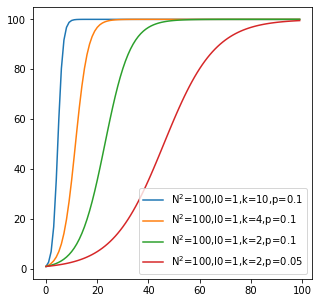

In [3]:
times=np.arange(0,100,1)

fig,ax = plt.subplots(1,1,figsize=(5, 5))

ax.plot(times,np.array([I(t,N2=100,I0=1,k=10,p=0.1) for t in times]),  label='N$^2$=100,I0=1,k=10,p=0.1')
ax.plot(times,np.array([I(t,N2=100,I0=1,k=4,p=0.1) for t in times]),   label='N$^2$=100,I0=1,k=4,p=0.1')
ax.plot(times,np.array([I(t,N2=100,I0=1,k=2,p=0.1) for t in times]),   label='N$^2$=100,I0=1,k=2,p=0.1')
ax.plot(times,np.array([I(t,N2=100,I0=1,k=2,p=0.05) for t in times]),  label='N$^2$=100,I0=1,k=2,p=0.05')

ax.legend(loc='lower right', frameon=True) 
plt.show()

## Simulation part

Draft your algorithm to simulate the spread of an epidemic from country A to country B.

Country A is modelled as a NxN grid of inidividuals:
- individuals can occupy discretised positions, organised in a grid of (width=N x height=N)
- each position can only be occupied by one individual at the same time 
- each individual can move from its position only by a discrete distance, horizontally and/or vertically or can remain fixed
- initial infection happens on day 0, at the North border and spreads to the nearest neighbours as explained in the introduction

We track if the disease spreads to country B, by adding an additional row of individuals in country A and by counting the infections there.

### Global definitions

In [4]:
CondDict = {}
CondDict['uninfected'] = 0
CondDict['infected'] = 1
CondDict['recovered'] = 2
CondDict['dead'] = 3
CondDict[0] = 'uninfected'
CondDict[1] = 'infected'
CondDict[2] = 'recovered'
CondDict[3] = 'dead'

### Classes definitions

#### Disease 

In [5]:
class Disease(object):
  '''
  The disease is characterised by the following probabilities (fixed in time):
  
  _pInfection:    probability of getting infected 
  _pRecovery:     probability of recovery, if alrady infected 
  _pDeath:        probability of dying, if already infected
  
  Each day, an individual:
  - if uninfected, can be infected or remain uninfected
  - if infected, can either recover or die or stay infected
  - if recovered or dead, cannot change state
  '''
  def __init__(self,pInfection,pRecovery,pDeath):  
    self._pInfection=pInfection
    self._pRecovery=pRecovery
    self._pDeath=pDeath

    if self._pDeath + self._pRecovery >= 1: 
      raise RuntimeError('self._pDeath + self._pRecovery should be < 1')
    if self._pInfection > 1:
      raise RuntimeError('self._pInfection should be <= 1')

#### Individual

In [6]:
class Individual(object):
  '''
  Tracks an individual through time
  The state of an individual consists of:
   - position at a given time
   - condition at a given time
  '''  

  def __init__(self):
    self._positions = []
    self._conditions = []
    self._times = []


  def setState(self, time=0, pos=(0,0), condition='uninfected'):
    '''
    Sets the state of the individual at time t 
    '''
    self._times.append(time)
    self._conditions.append(condition)
    self._positions.append(pos)

  def updatePosition(self, time=0, pos=(0,0)):
    '''
    Updates postition of an existing state 
    '''       
    try:
      idxTime = self._times.index(time)
      self._positions[idxTime] = pos
    except: 
      print('Requested update of position not possible')

  def updateCondition(self, time=0, condition='infected'):
    '''
    Updates condition of an existing state 
    '''       
    try:
      idxTime = self._times.index(time)
      self._conditions[idxTime] = condition
    except: 
      print('Requested update of condition not possible')    
     
  def getPosition(self,time=0):
    '''
    Returns position of existing state
    '''    
    try:
      idxTime = self._times.index(time)
      return self._positions[idxTime]
    except: 
      print('Requested state does not exist') 
    
  def getCondition(self,time=0):
    '''
    Returns condition of existing state
    '''
    try:
      idxTime = self._times.index(time)
      return self._conditions[idxTime]
    except: 
      print('Requested state does not exist')
    

#### Nation

In [7]:
class Nation(object):
  '''
  Individuals are organised in a nation. This class describes the spread of a disease in a simplified model:
   - individuals can occupy discretised positions, organised in a grid of (width x height)
   - each position can only be occupied by one individual at the same time 
   - each individual can move from its position only by a discrete distance, horizontally and/or vertically
   - initial infection happens on day 0, at the north border and spreads to the nearest neighbours of an infected individual every day
   
  Arguments:
    width : (int) width of the nation
    height: (int) height of the nation
            N.B.: a nation of height+1 will be created to track the infections in the bordering country
    I0:     (float) initial number of infected individuals
    maxTravelDistance: (int) the number of squares that each individual can move on a given day
  '''

  def __init__(self, width=10, height=10, I0=1, maxTravelDistance=0):
    
    if not isinstance(width, int) or not isinstance(height, int) or not isinstance(maxTravelDistance, int) or not isinstance(I0, int)\
    or width<=0 or height<=0 or maxTravelDistance < 0 or I0<=0:
      raise RuntimeError('Width, height, I0 have to be positive integers; maxTravelDistance must be non-negative')

    self._width = width
    self._height = height
    self._maxTravelDistance = maxTravelDistance
    self._I0 = I0

    self._N2 = width * height
    if self._I0 > self._width: raise RuntimeError('Initial number of infected individuals cannot exceed number of individuals at the border. Please lower I0')

    self._individuals = [] 
    self._currentTime = 0
 
  def createIndividuals(self):
    '''
    Creates instances of individuals, one per point in the width x (height+1) grid
    As a trick to track the infections to the bordering country, individuals are created also at height+1
    '''
    for x in range(self._width):
      column = []
      for y in range(self._height+1): 
        ind = Individual()
        ind.setState(time=0,pos=(x,y),condition='uninfected')
        column.append(ind)
      self._individuals.append(column)

  def setInitialInfected(self):
    '''
    Randomly samples a fraction of infected individuals from the border
    and updates their condition
    '''
    xInfected = random.sample(range(self._width), self._I0)
    for x in range(self._width):
      ind = self._individuals[x][0]
      if x in xInfected:
        ind.updateCondition(time=0,condition='infected')
  
  def setDisease(self,pInfection=0.10,pRecovery=0.2,pDeath=0.01):
    '''
    Creates the disease based on the specified parameters
    '''
    self._disease = Disease(pInfection,pRecovery,pDeath)    

  def getIndividualNNs(self,ind,time):
    '''
    Returns a list of the existing nearest neighbours (one position away horizontally OR vertically)
    '''
    (x,y)=ind.getPosition(time)
    allNNpositions = [(x,y+1),(x,y-1),(x+1,y),(x-1,y)]
    
    goodNNs = []
    for (xNN,yNN) in allNNpositions:
      if xNN >= 0 and xNN < self._width and yNN >= 0 and yNN < self._height+1:
        goodNNs.append(self._individuals[xNN][yNN])
    return goodNNs
            
  def evolveOneStep(self):
    '''
    Produces the evolution of one day:
    - creates the states of each individual at the new time
    - updates their position, if applicable
    - updates their condition based on the NNs of the previous day 
    '''
    
    self._currentTime += 1

    # keeps track of occupied positions at time t
    busyPositionsMap = []
    allPositionsMap = [(x,y) for x in range(self._width) for y in range(self._height+1)]

    for x in range(self._width):
      for y in range(self._height+1):
        
        ind = self._individuals[x][y]

        # Create state at new time, old position, old condition
        ind.setState(time=self._currentTime,
                     pos=ind.getPosition(time=self._currentTime-1),
                     condition=ind.getCondition(time=self._currentTime-1))

        # Update the condition ?
        if ind.getCondition(time=self._currentTime-1) == 'infected': 
          # Did you recover/die or stay infected? draw a sample from a multinomial distribution
          # it's like throwing a dice with three faces and each face has a different weight
          isRecovered,isDead,isStillInfected = rg.multinomial(1, [self._disease._pRecovery,self._disease._pDeath,1-self._disease._pRecovery-self._disease._pDeath], size=1).reshape(-1)
          if isRecovered==1:
            ind.updateCondition(time=self._currentTime, condition='recovered')
          elif isStillInfected==1:
            pass # do nothing 
          else:
            ind.updateCondition(time=self._currentTime, condition='dead')
        
        elif ind.getCondition(time=self._currentTime-1) == 'uninfected':
          # try to get infected, based on the NN of the previous day
          NNs = self.getIndividualNNs(ind=ind,time=self._currentTime-1)
          for NN in NNs:
            if NN.getCondition(time=self._currentTime-1) == 'infected':
              if rg.random() < self._disease._pInfection:
                ind.updateCondition(time=self._currentTime, condition='infected') 
                break # no need to be infected twice
        else: 
          pass # if recovered or died, there's nothing to update
      

        # Update the position if individual can move
        if self._maxTravelDistance > 0:
          # get old position and create a new candidate position, 
          oldx,oldy = ind.getPosition(time=self._currentTime-1)
          travelDistance = rg.integers(1,self._maxTravelDistance,endpoint=True)
          dx = rg.integers(1,travelDistance,endpoint=True)
          newx = oldx + dx                    * ( 1 if rg.random() < 0.5 else -1 )
          newy = oldy + (travelDistance - dx) * ( 1 if rg.random() < 0.5 else -1 )
          
          # accept new pos if not occupied by other individual, and within boundaries
          if newx > 0 and newx < self._width and newy > 0 and newy < self._height+1 \
          and (newx,newy) not in busyPositionsMap:
            ind.updatePosition(time=self._currentTime,pos=(newx,newy))
          
          # else get available positions and pick the nearest to old pos
          else: 
            availablePositionMap = list( set(allPositionsMap) - set(busyPositionsMap) )
            newx,newy=99999,99999
            for ax,ay in availablePositionMap:
              if (oldx-ax)**2+(oldy-ay)**2 < (oldx-newx)**2+(oldy-newy)**2:
                newx = ax
                newy = ay
            ind.updatePosition(time=self._currentTime,pos=(newx,newy))
            ####newx,newy = random.choice(availablePositionMap)
        
          # keep track of the used positions
          busyPositionsMap.append((newx,newy))

          
  def evolve(self,nDays=1):
    '''
    Produces the evolution of a number of days, specified by ndays
    '''
    for step in range(nDays):
      self.evolveOneStep()
            
  def getConditionsAtTime(self,time=0):
    '''
    Returns a 2D np.array with numerical information on the conditions of the individuals at time t,
    including bordering country
    '''
    data = np.ones((self._width,self._height+1), dtype=int)*99
    for x in range(self._width):
      for y in range(self._height+1):
        cond = self._individuals[x][y].getCondition(time=time)
        posX,posY = self._individuals[x][y].getPosition(time=time)
        data[posX,posY] = CondDict[cond]
    return data
  
  def getNwithConditionAtTime(self,time=0, cond='infected'):
    '''
    Returns the number of infected people at time t, inside the nation
    '''
    dataAll = self.getConditionsAtTime(time=time)
    dataNation = dataAll[:,:-1] # all, but last column
    numCond = CondDict[cond]
    return (dataNation == numCond).sum()
  
  def getBorderNwithConditionAtTime(self,time=0, cond='infected'):
    '''
    Returns the number of infected people at time t, in the border of the neighbouring country
    '''
    dataAll = self.getConditionsAtTime(time=time)
    dataBorder = dataAll[:,-1] # only last column
    numCond = CondDict[cond]
    return (dataBorder == numCond).sum()

  def plotAtTimes(self, times=[0,1]):
    '''
    Plots snapshots of the nation AND the border of the neighbouring country at specified times 
    '''
    fig, axes = plt.subplots(1, len(times), figsize=(5*len(times), 5))
    # create discrete colormap
    cmap = colors.ListedColormap(['white', 'red', 'green', 'black'])
    bounds = [-0.5,0.5,1.5,2.5,3.5]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    
    for i,time in enumerate(times):
      data = self.getConditionsAtTime(time)

      axes[i].imshow(data.T, cmap=cmap, norm=norm)

      # draw gridlines
      axes[i].grid(which='major', axis='both', linestyle='-', color='k', linewidth=1)
      axes[i].set_xticks(np.arange(-0.5, self._width-0.5, 1));
      axes[i].set_yticks(np.arange(-0.5, self._height+0.5, 1));
    
    plt.show()
        
  def plotInfectedEvolution(self,doFrac=True,doRet=False, doShow=True):
    '''
    Plots the fraction/number of infected,reco,dead,uninf people as a function of time, until current time.
    Returns the times as a np.array() and the fraction/number of infected people at each time as a np.array() with the same shape 
    '''
    times = np.arange(0,self._currentTime+1)
    Infected   = np.array([self.getNwithConditionAtTime(time,cond='infected')   for time in times])
    Recovered  = np.array([self.getNwithConditionAtTime(time,cond='recovered')  for time in times])
    Dead       = np.array([self.getNwithConditionAtTime(time,cond='dead')       for time in times])
    Uninfected = np.array([self.getNwithConditionAtTime(time,cond='uninfected') for time in times])
    
    if doFrac:
      Infected   = Infected   / float(self._N2)
      Recovered  = Recovered  / float(self._N2)
      Dead       = Dead       / float(self._N2)
      Uninfected = Uninfected / float(self._N2)
      
    if doShow:
      fig, ax = plt.subplots(1, 1, figsize=(5, 5))
      ax.plot(times,Infected, 'red', label='infected')
      ax.plot(times,Recovered, 'green', label='recovered')
      ax.plot(times,Dead, 'black', label='dead')
      ax.plot(times,Uninfected, 'gray', label='uninfected')
      ax.legend(loc='upper right', frameon=True) 

      ax.set_xlabel('time (days)')
      if doFrac:
        ax.set_ylabel('Fraction of individuals')
      else:
        ax.set_ylabel('Number of individuals')
    
      plt.show()
    
    if doRet: 
      return Infected,times


#### Exercise 0
Let us assume width=10 x height=5 individuals over the span of 100 days and get our simulation running, using some initial parameters. 

Check the sanity of the algorithm, observing snapshots of the epidemic at different times in the case where  pInfection=1, pRecovery=0, pDeath=0.

Then play around with the parameters to see how the epidemic unrolls in different cases

In [37]:
nDays = 100

nation = Nation(width=10, height=10, I0=1, maxTravelDistance=0)
nation.createIndividuals()
nation.setInitialInfected()
nation.setDisease(pInfection=0.25,pRecovery=0.1,pDeath=0.01)
nation.evolve(nDays)

Visualize consecutive snapshots of the epidemic: this is useful to understand that the algorithm is working as expected

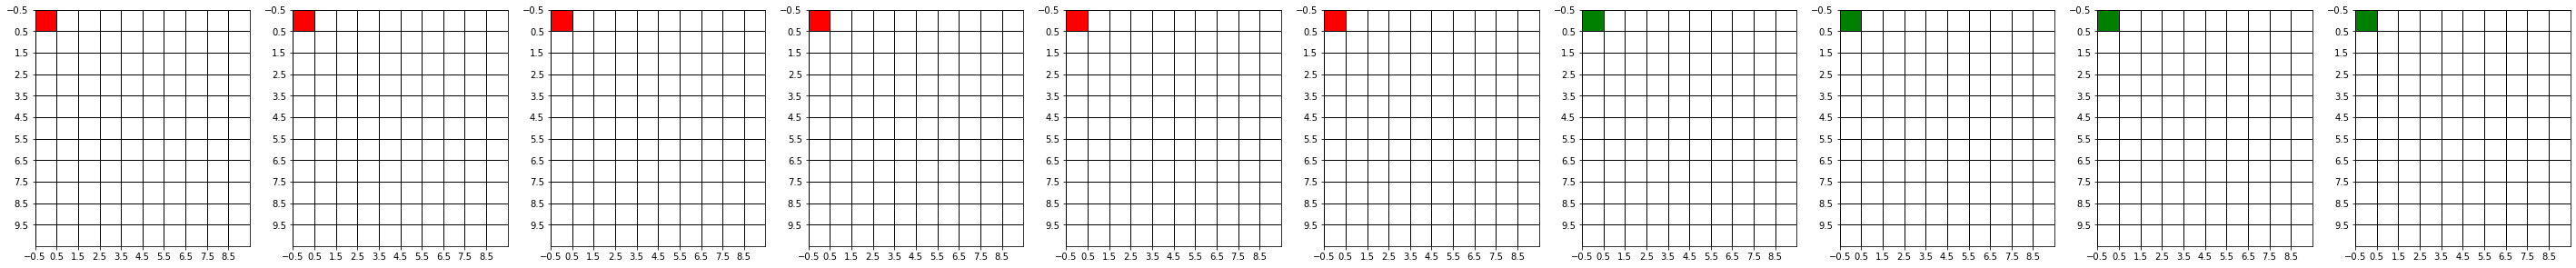

In [38]:
nation.plotAtTimes(times=np.arange(0,10,1))

Visualize snapshots of the epidemic at various stages of the epidemics, e.g. every 10 days

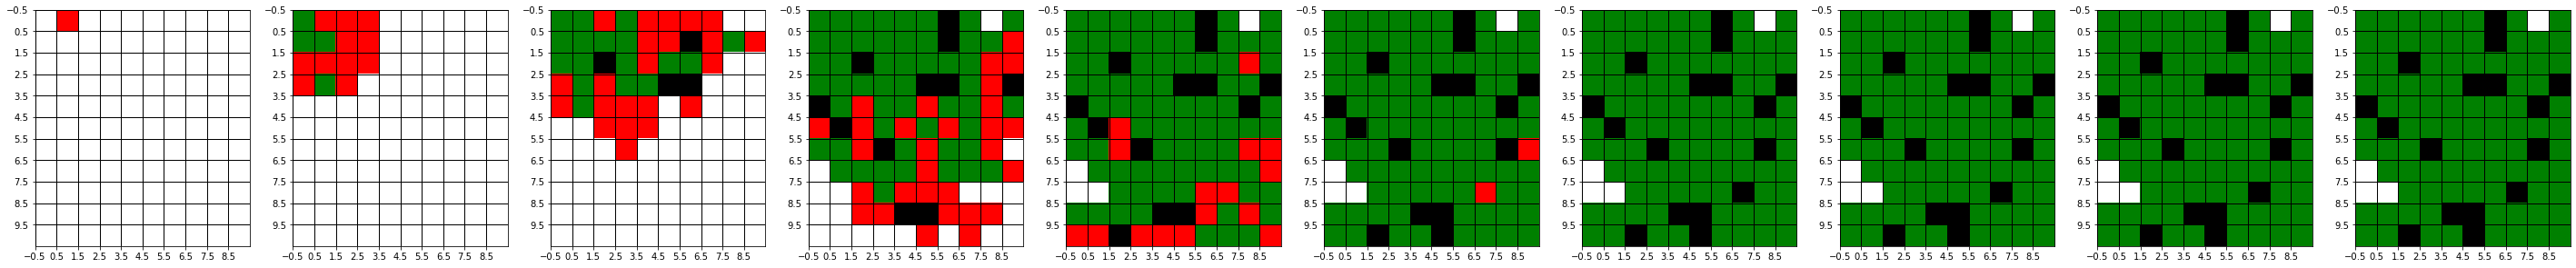

In [21]:
nation.plotAtTimes(times=np.arange(0,nDays,10))

Visualize the evolution of the fraction of infected, recovered, dead and uninfected individuals over time

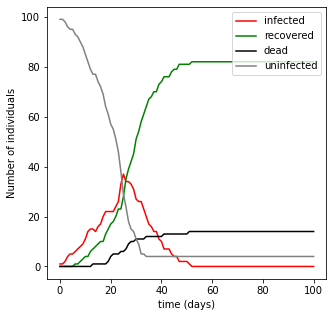

In [22]:
nation.plotInfectedEvolution(doFrac=False)

#### Exercise 1: Transmission to country B
Let us do the following assumptions: 10x10 individuals over the span of 100 days, no mobility, only NN infection, one initial infected person on day 0.  

Find the threshold probability of infection p* such that the virus will be transmitted to the bordering country only ~ 5% of the times:

1) Play around with the probabilities, `pRecovery`, `pDeath`, `pInfection`, to get a feeling of the range of values that could prevent the disease from spreading.

2) Fix `pRecovery`, `pDeath`, and decide on a reasonable range of values of `pInfection`, to scan. Then run 500 simulations for each value and determine the fraction of simulations where there is at least one infection at the border of the neighbouring country. (*Hint*: scan at least 5 values) 

3) Plot this fraction for the different values of `pInfection` and fit it to a polynomial using the least squares method, (e.g. following the [sklearn implementation](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions) )

4) Estimate p* 

5) *Optional*: assuming that the measurement of the fraction is subjected to random errors (normal distribution), repeat the simulation another couple of times; estimate an uncertainty for p* .  *Hint*: use the least squares method with errors on y, after transforming to poylnomial features

[Note for me: in reality, one could calculate already the uncertainty using the treatment for efficiencies]

In [33]:
def getFractionForPInfScan(pInfectionScan = np.array([0.05, 0.10, 0.2, 0.3, 0.5]), nExps=10, width=10, height=10):

  I0 = 1
  pRecovery = 0.30
  pDeath = 0.01

  nDays = 100

  timeFirstInfections = np.zeros((pInfectionScan.shape[0], nExps))
  fractions = np.zeros((pInfectionScan.shape[0]))

  for ip,p in enumerate(pInfectionScan):
    for iExp in tqdm(np.arange(nExps)):
      #print('  iExp={}'.format(iExp))
    
      nation = Nation(width=width, height=height, I0=I0)
      nation.createIndividuals()
      nation.setInitialInfected()
      nation.setDisease(pInfection=p,pRecovery=pRecovery,pDeath=pDeath)
    
      for iDay in np.arange(1,nDays+1):
        nation.evolve(1)
        if nation.getBorderNwithConditionAtTime(time=iDay,cond='infected') > 0:
          timeFirstInfections[ip,iExp] = iDay
          #print('  time first infection = {}'.format(timeFirstInfections[ip,iexp]))
          break

    fractions[ip] = (timeFirstInfections[ip,:]>0).mean()
  
  return fractions

In [34]:
pInfectionScan_N10_1 = np.array([0.10, 0.15, 0.20, 0.25])
fractions_N10_11 = getFractionForPInfScan(pInfectionScan_N10_1, nExps=100, width=10, height=10)
fractions_N10_11

100%|██████████| 100/100 [00:21<00:00,  4.64it/s]


array([0.  , 0.  , 0.04, 0.18])

In [858]:
def fitFractions(pInfectionScan,fractions, degree=3):

  X = pInfectionScan.copy()
  Y = fractions.copy()
  X = X.reshape(-1,1)

  model = Pipeline([('poly', PolynomialFeatures(degree=degree)),
                  ('linear', LinearRegression(fit_intercept=False))])
  model = model.fit(X, Y)

  #Ypred = model.predict(X)
  #print('Coefficient of determination: %.2f' % r2_score(Y, Ypred))
  
  return model

In [903]:
model = fitFractions(pInfectionScan_N10_1,fractions_N10_11)
newX = np.linspace(0.10, 0.25, 200)
newY = model.predict(newX.reshape(-1,1))
#model.named_steps['linear'].coef_

array([ -0.098     ,   2.79333333, -26.4       ,  82.66666667])

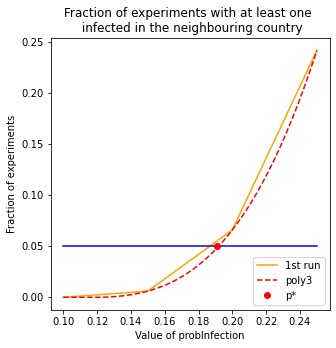

Extracted value of p*= [[0.19120603]]


In [899]:
line = np.ones(newX.shape)*0.05

# Find the intersection point between the line and the function
idx = np.argwhere(np.diff(np.sign(newY-line)))

fig,ax = plt.subplots(1,1,figsize=(5, 5))
ax.plot(X,Y,       '-', label='1st run', color='orange')
ax.plot(newX,newY, '--',label='poly3', color='red')
ax.plot(newX,line, '-', color='blue')
ax.plot(newX[idx], line[idx], 'ro', label='p*')
ax.legend(loc='lower right', frameon=True)
ax.set_xlabel('Value of probInfection')
ax.set_ylabel('Fraction of experiments')
ax.set_title('Fraction of experiments with at least one \n infected in the neighbouring country')
plt.show()

print('Extracted value of p*=', newX[idx])

<span style="color:RED"> TODO prediction band missing </span>.


Here are a few more runs of the experiment

In [415]:
fractions_N10_22 = getFractionForPInfScan(pInfectionScan_N10_1, nExps=500, width=10, height=10)
fractions_N10_22

ip=0, p=0.1
ip=1, p=0.15
ip=2, p=0.2
ip=3, p=0.25


array([0.   , 0.008, 0.058, 0.218])

In [416]:
fractions_N10_33 = getFractionForPInfScan(pInfectionScan_N10_1, nExps=500, width=10, height=10)
fractions_N10_33

ip=0, p=0.1
ip=1, p=0.15
ip=2, p=0.2
ip=3, p=0.25


array([0.   , 0.006, 0.07 , 0.212])

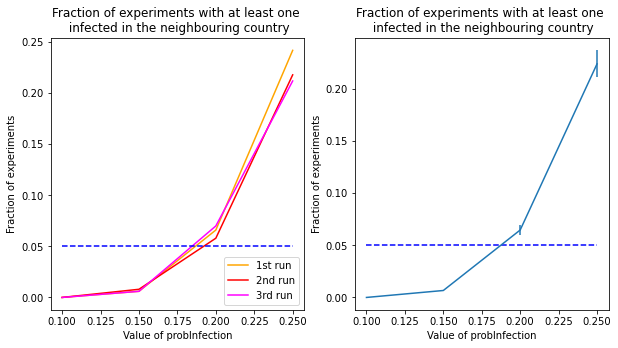

In [684]:
fig,ax = plt.subplots(1,2,figsize=(5*2, 5))
ax[0].plot(pInfectionScan_N10_1,fractions_N10_11, '-', label='1st run', color='orange')
ax[0].plot(pInfectionScan_N10_1,fractions_N10_22, '-', label='2nd run', color='red')
ax[0].plot(pInfectionScan_N10_1,fractions_N10_33, '-', label='3rd run', color='magenta')
ax[0].plot(pInfectionScan_N10_1,np.array([0.05 for p in enumerate(pInfectionScan_N10_1)]), '--',color='blue')
ax[0].legend(loc='lower right', frameon=True)
ax[0].set_xlabel('Value of probInfection')
ax[0].set_ylabel('Fraction of experiments')
ax[0].set_title('Fraction of experiments with at least one \n infected in the neighbouring country')


ys = np.vstack((fractions_N10_11,fractions_N10_22,fractions_N10_33))
ymean = ys.mean(axis=0)
yerr = np.sqrt(ys.var(axis=0))
ax[1].errorbar(x=pInfectionScan_N10_1, y=ymean, yerr=yerr)
#ax[1].plot(pInfectionScan_N10_1,fit_fn(pInfectionScan_N10_1),color='b',label='fit')
ax[1].plot(pInfectionScan_N10_1,np.array([0.05 for p in enumerate(pInfectionScan_N10_1)]), '--',color='blue')
ax[1].set_xlabel('Value of probInfection')
ax[1].set_ylabel('Fraction of experiments')
ax[1].set_title('Fraction of experiments with at least one \n infected in the neighbouring country')

plt.show()
#print(timeFirstInfections)

====> for these parameters:  p* ~ 0.18


#### Exercise 2 Transmission to Country B, as a function of N
Repeat exercise 1 for different values of NxN. 

Scan e.g. N=5, N=10, N=20 (do not take N too high, otherwise simulation will take forever)

How does p* depend on N ?

Suggestion: use a similar range as in the previous exercise. 
Start with fewer experiments, to get an idea of the trend. Then run more simulations.

In [418]:
pInfectionScan_N10 = np.array([0.10, 0.15, 0.20, 0.25])
fractions_N10 = getFractionForPInfScan(pInfectionScan_N10, nExps=500, width=10, height=10)
fractions_N10

ip=0, p=0.1
ip=1, p=0.15
ip=2, p=0.2
ip=3, p=0.25


array([0.   , 0.01 , 0.064, 0.194])

In [419]:
pInfectionScan_N20 = np.array([0.10, 0.15, 0.20, 0.25])
fractions_N20 = getFractionForPInfScan(pInfectionScan_N20, nExps=500, width=15, height=15)
fractions_N20

ip=0, p=0.1
ip=1, p=0.15
ip=2, p=0.2
ip=3, p=0.25


array([0.   , 0.   , 0.03 , 0.194])

In [420]:
pInfectionScan_N5 = np.array([0.10, 0.15, 0.20, 0.25])
fractions_N5 = getFractionForPInfScan(pInfectionScan_N5, nExps=500, width=5, height=5)
fractions_N5

ip=0, p=0.1
ip=1, p=0.15
ip=2, p=0.2
ip=3, p=0.25


array([0.008, 0.036, 0.14 , 0.294])

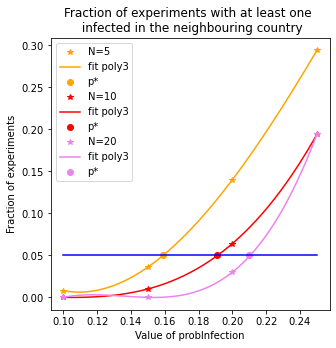

Extracted p* values
N=5,  p*=[[0.15879397]]
N=10, p*=[[0.19120603]]
N=20, p*=[[0.21005025]]


In [982]:
model_N10 = fitFractions(pInfectionScan_N10,fractions_N10)
model_N20  = fitFractions(pInfectionScan_N20,fractions_N20)
model_N5 = fitFractions(pInfectionScan_N5,fractions_N5)

newX = np.linspace(0.10, 0.25, 200)
line = np.ones(newX.shape)*0.05

newY_N5 = model_N5.predict(newX.reshape(-1,1))
newY_N10 = model_N10.predict(newX.reshape(-1,1))
newY_N20 = model_N20.predict(newX.reshape(-1,1))


idx_N5 = np.argwhere(np.diff(np.sign(newY_N5-line)))
idx_N10 = np.argwhere(np.diff(np.sign(newY_N10-line)))
idx_N20 = np.argwhere(np.diff(np.sign(newY_N20-line)))

fig,ax = plt.subplots(1,1,figsize=(5, 5))

ax.plot(pInfectionScan_N5,fractions_N5, '*', label='N=5', color='orange')
ax.plot(newX,newY_N5, '-', label='fit poly3', color='orange')
ax.plot(newX[idx_N5], line[idx_N5], 'ro', label='p*', color='orange')

ax.plot(pInfectionScan_N10,fractions_N10,'*', label='N=10', color='red')
ax.plot(newX,newY_N10, '-', label='fit poly3', color='red')
ax.plot(newX[idx_N10], line[idx_N10], 'ro', label='p*', color='red')

ax.plot(pInfectionScan_N20,fractions_N20, '*', label='N=20', color='violet')
ax.plot(newX,newY_N20, '-', label='fit poly3', color='violet')
ax.plot(newX[idx_N20], line[idx_N20], 'ro', label='p*', color='violet')

ax.plot(newX,line, '-', color='blue')

ax.legend(loc='upper left', frameon=True)
ax.set_xlabel('Value of probInfection')
ax.set_ylabel('Fraction of experiments')
ax.set_title('Fraction of experiments with at least one \n infected in the neighbouring country')
plt.show()

print('Extracted p* values')
print('N=5,  p*={}'.format(newX[idx_N5]))
print('N=10, p*={}'.format(newX[idx_N10]))
print('N=20, p*={}'.format(newX[idx_N20]))

#print(timeFirstInfections)

Result: In order to contain the pandemic in a smaller country, one needs a less infective disease

N.B.: here I fitted with a polynomial of degree 3, with only four points; at the limit of applicability

#### Exercise 3 Quarantine versus free travel
So far we have considered cases where the individuals cannot move from their fixed position. What happens when the people are allowed to move?

Let us concentrate on country A; fix the various parameters of the simulation to some choice and compare the cases when
`_maxTravelDistance=0` = 0 and `_maxTravelDistance=M`, with M some value of your choice.

In particular:

1. How does the number of total infections varies with time in the two cases? Plot the curve.  
2. For the two cases separately, repeat the simulation a few times, determine an average curve and its variance 
2. Comment on the shapes of the average curves in the two cases. 

Case 1: _maxTravelDistance=0

In [53]:
def getAvgCurves(maxTravelDistance=0):
  nExp = 10
  nDays = 100
  listInfected = []

  for iExp in range(nExp):

    nation = Nation(width=10, height=10, I0=1, maxTravelDistance=maxTravelDistance)
    nation.createIndividuals()
    nation.setInitialInfected()
    nation.setDisease(pInfection=0.25,pRecovery=0.10,pDeath=0.02)
    nation.evolve(nDays-1)

    Infected,times = nation.plotInfectedEvolution(doFrac=False,doRet=True,doShow=False)
    listInfected.append(Infected)

  arInfecteds = np.vstack((listInfected[:]))
  AvgInfecteds = arInfecteds.mean(axis=0)
  VarInfecteds = arInfecteds.var(axis=0)

  fit = np.polyfit(times,AvgInfecteds,9)
  fit_fn = np.poly1d(fit)

  fix,ax = plt.subplots(1,1,figsize=(5,5))
  for iInfected in listInfected:
    ax.plot(times,iInfected, '-', linewidth='0.2')
  ax.plot(times,AvgInfecteds,                       color='magenta',label='$\mu$')
  ax.plot(times,AvgInfecteds+np.sqrt(VarInfecteds), color='r', label='$\mu+\sigma$')
  ax.plot(times,AvgInfecteds-np.sqrt(VarInfecteds), color='r', label='$\mu-\sigma$')
  ax.plot(times,fit_fn(times),                      color='b',label='fit')

  return times,AvgInfecteds,VarInfecteds

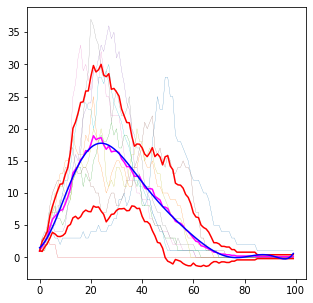

In [55]:
times0,AvgInfecteds0,VarInfecteds0 = getAvgCurves(maxTravelDistance=0)

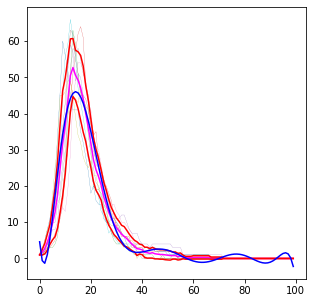

In [56]:
times5,AvgInfecteds5,VarInfecteds5 = getAvgCurves(maxTravelDistance=5)

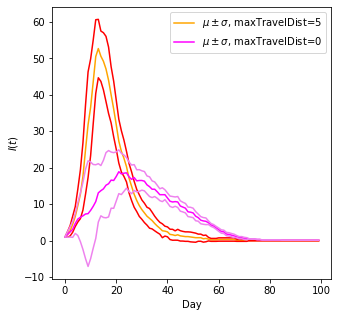

In [57]:
fix,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(times5,AvgInfecteds5,                       color='orange',label='$\mu\pm\sigma$, maxTravelDist=5')
ax.plot(times5,AvgInfecteds5+np.sqrt(VarInfecteds5), color='r',   )
ax.plot(times5,AvgInfecteds5-np.sqrt(VarInfecteds5), color='r', )

ax.plot(times5,AvgInfecteds0,                       color='magenta',label='$\mu\pm\sigma$, maxTravelDist=0')
ax.plot(times5,AvgInfecteds0+np.sqrt(VarInfecteds5), color='violet')
ax.plot(times5,AvgInfecteds0-np.sqrt(VarInfecteds5), color='violet')

ax.set_xlabel('Day')
ax.set_ylabel('$I(t)$')


ax.legend(loc='upper right')

x=7 y=0 pos= (7, 0)


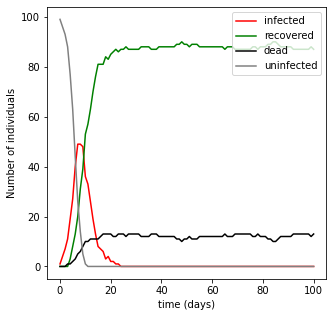

In [1143]:
nDays = 100

nation = Nation(width=10, height=10, I0=1, maxTravelDistance=5)
nation.createIndividuals()
nation.setInitialInfected()
nation.setDisease(pInfection=0.50,pRecovery=0.25,pDeath=0.02)
nation.evolve(nDays)

Infected,times = nation.plotInfectedEvolution(doFrac=False,doRet=True)

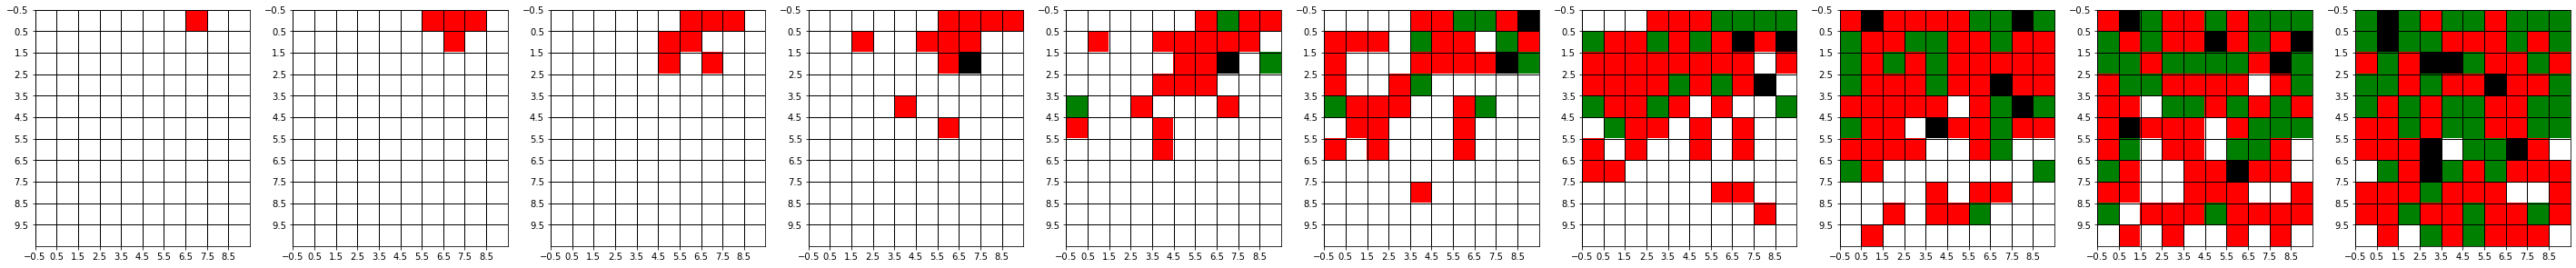

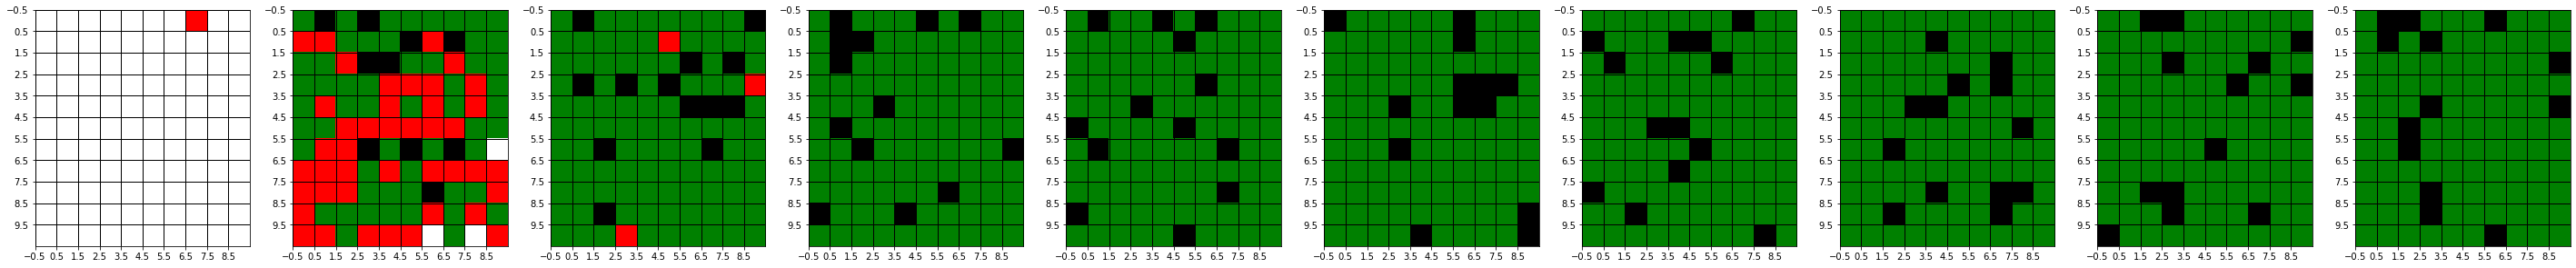

In [1144]:
nation.plotAtTimes(times=np.arange(0,10,1))
nation.plotAtTimes(times=np.arange(0,nDays,10))

In [ ]:
nExp = 20
nDays = 100
listInfected = []

for iExp in range(nExp):

  nation = Nation(width=50, height=50, I0=1, maxTravelDistance=0)
  nation.createIndividuals()
  nation.setInitialInfected()
  nation.setDisease(pInfection=0.6,pRecovery=0.25,pDeath=0.02)
  nation.evolve(nDays-1)

  Infected,times = nation.plotInfectedEvolution(doFrac=False,doRet=True,doShow=False)
  listInfected.append(Infected)
  

Answer: when the position of the individuals in the grid is fixed, it very much resembles a country with quarantine, i.e. we observe that the curve is flattened, compared to the case where the individuals can move freely in the country

#### Bonus exercise: analytic versus numerical simulation

For the case of restricted travel (maxTravelDistance=0) and in the simplified situation where where pDeath=0, pRecovery=0,: compare the curves obtained by the simulation and the analytic solution of the differential equation obtained in the beginning: do they match? 

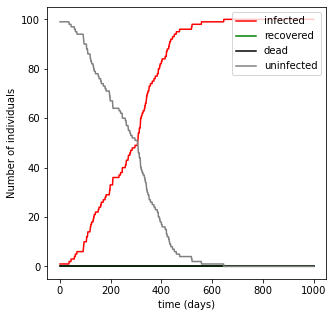

In [775]:
nDays = 1000

nation = Nation(width=10, height=10, I0=1, maxTravelDistance=0)
nation.createIndividuals()
nation.setInitialInfected()
nation.setDisease(pInfection=0.01,pRecovery=0.,pDeath=0.)
nation.evolve(nDays)

Infected,times = nation.plotInfectedEvolution(doFrac=False,doRet=True)

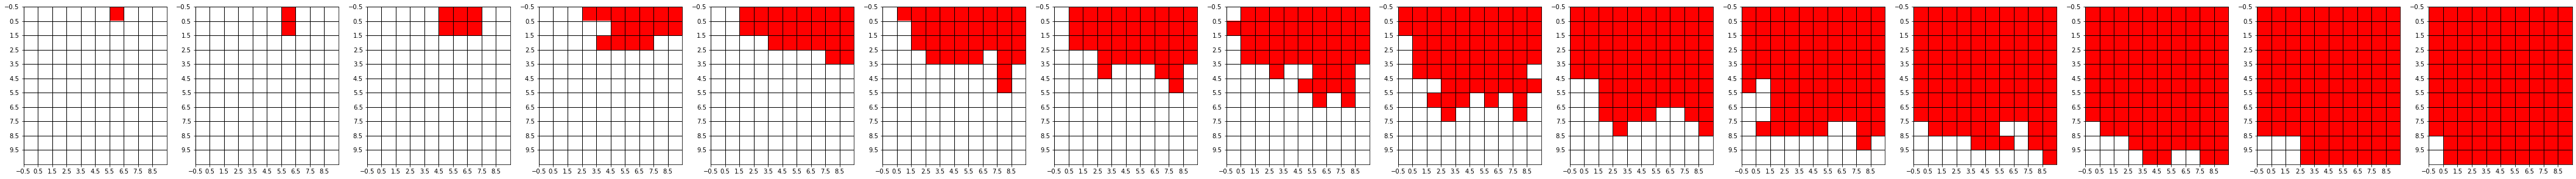

In [776]:
nation.plotAtTimes(times=np.arange(0,600,40))

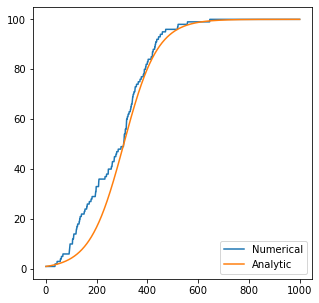

In [779]:
fix,ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(times,Infected,label='Numerical')
ax.plot(times,np.array([I(t,N2=100,I0=1,k=1.5,p=0.01) for t in times]), label='Analytic')
ax.legend(loc='lower right', frameon=True) 
plt.show()

### Statistics, some useful examples
Example usage of multinomial distribution:
I do 10000 experiments where I throw the three-faced dice once; each face has a different probability

In [58]:
results = rg.multinomial(1, [0.1,0.5,1-0.1-0.5], size=10000)
print(results[:,0].mean())
print(results[:,1].mean())
print(results[:,2].mean())
a = rg.multinomial(1, [0.1,0.5,1-0.1-0.5], size=1)
print(a)
print(a.reshape(-1))
b,c,d=a.reshape(-1)
print(b,c,d)

0.1013
0.5039
0.3948
[[0 1 0]]
[0 1 0]
0 1 0


Docstring:
multinomial(n, pvals, size=None)

Draw samples from a multinomial distribution.

The multinomial distribution is a multivariate generalization of the
binomial distribution.  Take an experiment with one of ``p``
possible outcomes.  An example of such an experiment is throwing a dice,
where the outcome can be 1 through 6.  Each sample drawn from the
distribution represents `n` such experiments.  Its values,
``X_i = [X_0, X_1, ..., X_p]``, represent the number of times the
outcome was ``i``.

Parameters
----------
n : int or array-like of ints
    Number of experiments.
pvals : sequence of floats, length p
    Probabilities of each of the ``p`` different outcomes.  These
    must sum to 1 (however, the last element is always assumed to
    account for the remaining probability, as long as
    ``sum(pvals[:-1]) <= 1)``.
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn.  Default is None, 

Average Number of NN?

In [ ]:
def avgNumberNNs(width=10.,height=10.):
  '''
  return the average number of Nearest Neighbours in this setting
  '''
  N=width*height
  weights   = np.array([(N-2)**2, (N-2)*4, 4]) / N**2
  assert weights.sum()==1
  number_NNs= np.array([4,3,1])
  return (weights * number_NNs).sum()
print(avgNumberNNs(3,3),avgNumberNNs(10,10),avgNumberNNs(50,50))